# Game Music dataset: data cleaning and exploration
The goal with this notebook is cleaning the dataset to make it usable as well as providing a descriptive analysis of the dataset features.

## Data loading and cleaning

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import pandas as pd
from ast import literal_eval
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('midi_dataframe.csv', parse_dates=[11])
num_midis_before = len(df)
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(num_midis_before,
        len(df.groupby(['tgdb_platform', 'tgdb_gametitle'])),
        (df.tgdb_gametitle.notnull().sum())))
df.head()

There is 31685 midi files, from 3388 games, with 31249 midis matched with tgdb


,brand,console,game,title,file_name,tgdb_genres,tgdb_id,tgdb_developer,tgdb_publisher,tgdb_platform,tgdb_gametitle,tgdb_releasedate,tgdb_players,tgdb_rating,tgdb_esrb,tgdb_overview
0,Nintendo,NES,10-Yard Fight,Kick Off,b5da1581fd2b425122446a638363a28296aee817.mid,['Sports'],317.0,Nintendo,Nintendo,Nintendo Entertainment System (NES),10-Yard Fight,1985-10-18,2,4.5714,E - Everyone,The game is viewed in a top-down perspective a...
1,Miscellaneous,Arcade,1941: Counter Attack,Krote Armor Stage,efe29bdfc97d46a327467ea5d6e36bff6edc4223.mid,['Shooter'],2434.0,Capcom,Capcom,Arcade,1941: Counter Attack,1990-02-01,2,6.3333,NaN,The goal is to shoot down enemy airplanes and ...
2,Miscellaneous,Arcade,1941: Counter Attack,Level 6 Section 1,a356a1fd4960e4faa875c13bf7d03cfef3255cfd.mid,['Shooter'],2434.0,Capcom,Capcom,Arcade,1941: Counter Attack,1990-02-01,2,6.3333,NaN,The goal is to shoot down enemy airplanes and ...
3,Computer Systems,Commodore 64,1942,Main Theme,52e23ff501c107b2055d543d8249e96f43eab97e.mid,['Shooter'],6434.0,NaN,Elite,Commodore 64,1942,NaT,1,7.0000,NaN,1942 is set in the Pacific theater of World Wa...
4,Nintendo,NES,1943,Assault on Surface Forces B,26634701e919c25fddd82b00d63d75e1dedb5326.mid,['Shooter'],1018.0,Capcom,Capcom,Nintendo Entertainment System (NES),1943: The Battle of Midway,1987-06-01,2,4.5000,E - Everyone,The game is set in the Pacific theater of Worl...


We keep only files matched with tgdb and check that every midi file is only present once, if not we drop the rows.

In [22]:
num_dup = df.duplicated(subset='file_name').sum()
df.drop_duplicates(subset='file_name', inplace=True)
print('There was %d duplicated midi files, %d midis left'%(num_dup, len(df)))

There was 2 duplicated midi files, 31683 midis left


Since we are interested in the genre, we only keep midis that have one.

In [4]:
num_genres_na = df.tgdb_genres.isnull().sum()
df.dropna(subset=['tgdb_genres'], inplace=True)
print("We removed %d midis, %d midis left"%(num_genres_na, len(df)))

We removed 436 midis, 31247 midis left


Then, there are some categories, such as Medleys or Piano only that are not interesting.

There is also a big "remix" scene on vgmusic, so we also remove those.

In [5]:
categories_filter = df.console.isin(['Medleys', 'Piano Only'])
remix_filter = df.title.str.contains('[Rr]emix')

df = df[~categories_filter & ~remix_filter]
print('We removed %d midis from Medleys and Piano categories'%categories_filter.sum())
print('We removed %d midis containing "remix" in their title'%remix_filter.sum())
print('%d midis left'%len(df))

We removed 872 midis from Medleys and Piano categories
We removed 1860 midis containing "remix" in their title
28537 midis left


There often exists several versions of the same midi file, most of the time denoted by 'title (1)', 'title (2)', etc.

We also consider removing those, but keeping only the one with the highest value, or if there are several with the same title, we randomly keep one.

In [6]:
num_midis_before = len(df)

df_stripped = df.copy()
df_stripped.title = df.title.str.replace('\(\d+\)', '').str.rstrip()
df_stripped['rank'] = df.title.str.extract('\((\d+)\)', expand=False)
df = df_stripped.sort_values(by='rank', ascending=False).groupby(['brand', 'console', 'game', 'title']).first().reset_index()
print("We removed %d midis, %d midis left"%(num_midis_before-len(df), len(df)))

We removed 6358 midis, 22179 midis left


We also check if the midis files are valid by using mido and trying to load them.

In [7]:
from mido import MidiFile

bad_midis = []
for file in df['file_name']:
    try:
        midi = MidiFile("full/" + file)
    except:
        bad_midis.append(file)
df = df.loc[df.file_name.apply(lambda x: x not in bad_midis)]
print("We removed %d midis, %d midis left"%(len(bad_midis), len(df)))

We removed 118 midis, 22061 midis left


The final numbers after preliminary data cleaning are:

In [8]:
num_games = len(df.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df),
        num_games,
        (df.tgdb_gametitle.notnull().sum())))

There is 22061 midi files, from 3236 games, with 22061 midis matched with tgdb


## Data Exploration

## General statistics
We first begin by some general statistics about the dataset.

The number of gaming platforms is computed.

In [10]:
print('There is %d platforms'%df.tgdb_platform.nunique())

There is 62 platforms


Statistics concerning the number of games per platform are computed.

,0
count,64.000000
mean,52.921875
std,83.881115
min,1.000000
25%,3.000000
50%,16.000000
75%,62.750000
max,395.000000


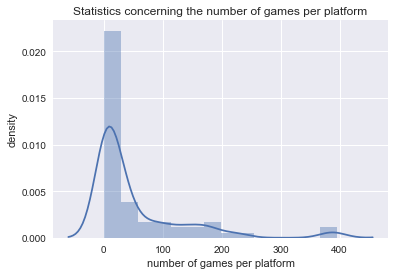

In [54]:
ax = sns.distplot(df.drop_duplicates(subset=['tgdb_platform', 'tgdb_gametitle']).groupby('tgdb_platform').size().to_frame())
ax.set_xlabel("number of games per platform")
ax.set_ylabel("density")
ax.set_title("Statistics concerning the number of games per platform")
df.drop_duplicates(subset=['tgdb_platform', 'tgdb_gametitle']).groupby('tgdb_platform').size().to_frame().describe()

Statistics concerning the number of midis per platform are computed.

,0
count,64.000000
mean,488.265625
std,1070.063256
min,1.000000
25%,9.000000
50%,67.000000
75%,337.750000
max,6568.000000


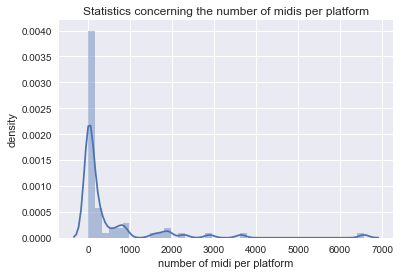

In [58]:
ax = sns.distplot(df.groupby('tgdb_platform').size().to_frame())
ax.set_xlabel("number of midi per platform")
ax.set_ylabel("density")
ax.set_title("Statistics concerning the number of midis per platform")
df.groupby('tgdb_platform').size().to_frame().describe()

Statistics concerning the number of midi per game.

,0
count,3387.000000
mean,9.226159
std,22.469805
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,429.000000


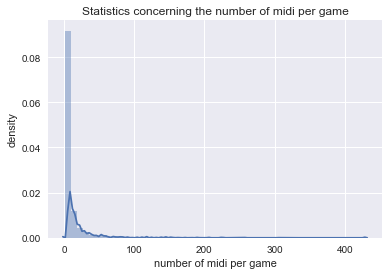

In [57]:
ax = sns.distplot(df.groupby(['tgdb_platform', 'tgdb_gametitle']).size().to_frame())
ax.set_xlabel("number of midi per game")
ax.set_ylabel("density")
ax.set_title("Statistics concerning the number of midi per game")
df.groupby(['tgdb_platform', 'tgdb_gametitle']).size().to_frame().describe()

It can be noted that most of the data we have follow power laws.

### Genres analysis
We currently had list of genres, for more convenience, we rework the dataframe to make several row of a midi if it had several genres.

In [14]:
genres = df.tgdb_genres.map(literal_eval, 'ignore').apply(pd.Series).stack().reset_index(level=1, drop=True)
genres.name = 'tgdb_genres'
genres_df = df.drop('tgdb_genres', axis=1).join(genres)

print("There is %d different genres"%genres_df.tgdb_genres.nunique())

There is 19 different genres


In [15]:
genres_df.to_csv("midi_dataframe_cleaned.csv")

Here follows the percentage of games belonging to each genre and of midis for each genres.

In [16]:
genres_df.drop_duplicates(subset=['tgdb_platform', 'tgdb_gametitle'])\
    .groupby(['tgdb_genres']).size().to_frame()\
    .sort_values(0, ascending = False)/num_games*100

,0
tgdb_genres,
Action,35.166873
Role-Playing,10.321384
Platform,9.394314
Shooter,9.177998
Fighting,8.498146
Adventure,6.736712
Puzzle,5.469716
Racing,4.388133
Sports,4.295426


In [17]:
genres_df.groupby(['tgdb_genres']).size().to_frame().sort_values(0, ascending = False)/len(df)*100

,0
tgdb_genres,
Action,38.515933
Role-Playing,29.790127
Platform,22.746022
Adventure,21.649064
Shooter,10.149132
Fighting,8.317846
Puzzle,6.686007
Sports,5.072300
Strategy,4.936313


The number of genres is 19, and could be reduced to 10 if we consider only the genres for which we have at least 3% dataset coverage or 5 if we consider only the genres for which we have at least 9% dataset coverage.

# Analysing length of Midis

To get a quick idea of the length of the midi tracks, we average the duration of 500 randomly sampled ones and obtain the average length of a midi track in seconds.

In [ ]:
from mido import MidiFile

average_length = 0
for filename in df.sample(500)['file_name']:
    average_length += MidiFile("full/" + filename).length

average_length /= 500
average_length